In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions, preprocess_input

In [ ]:
model = tf.keras.applications.MobileNetV2(weights="imagenet")
model.trainable = False

In [ ]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    image = image[None, ...]
    return image

In [ ]:
img_path = tf.keras.utils.get_file(
    'agaric.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/Miju_Mishmi_women_from_Anjaw_district_in_their_traditional_attire.jpg/1920px-Miju_Mishmi_women_from_Anjaw_district_in_their_traditional_attire.jpg'
)
image_raw = tf.io.read_file(img_path)
image_tensor = tf.image.decode_jpeg(image_raw, channels=3)
image = preprocess(image_tensor)

In [ ]:
original_preds = model.predict(image)
print("Original prediction:", decode_predictions(original_preds, top=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Original prediction: [[('n04136333', 'sarong', np.float32(0.69364744))]]


In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

@tf.function
def create_adversarial_pattern(image, label):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad

# Create one-hot label for the true class
label_index = np.argmax(original_preds[0])
true_label = tf.one_hot(label_index, original_preds.shape[-1])
true_label = tf.reshape(true_label, (1, -1))

perturbations = create_adversarial_pattern(image, true_label)
epsilon = 0.01
adversarial_image = image + epsilon * perturbations
adversarial_image = tf.clip_by_value(adversarial_image, -1.0, 1.0)

In [ ]:
adv_preds = model.predict(adversarial_image)
print("Adversarial prediction:", decode_predictions(adv_preds, top=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Adversarial prediction: [[('n03089624', 'confectionery', np.float32(0.116549395))]]


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def overlay_heatmap(heatmap, image, alpha=0.4):
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    image = image.numpy().squeeze()
    image = ((image + 1) * 127.5).astype(np.uint8)
    superimposed = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed

In [ ]:
last_conv_layer_name = 'Conv_1'  # last conv layer in MobileNetV2

heatmap_clean = make_gradcam_heatmap(image, model, last_conv_layer_name)
heatmap_adv = make_gradcam_heatmap(adversarial_image, model, last_conv_layer_name)

img_overlay_clean = overlay_heatmap(heatmap_clean, image[0])
img_overlay_adv = overlay_heatmap(heatmap_adv, adversarial_image[0])

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_468']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


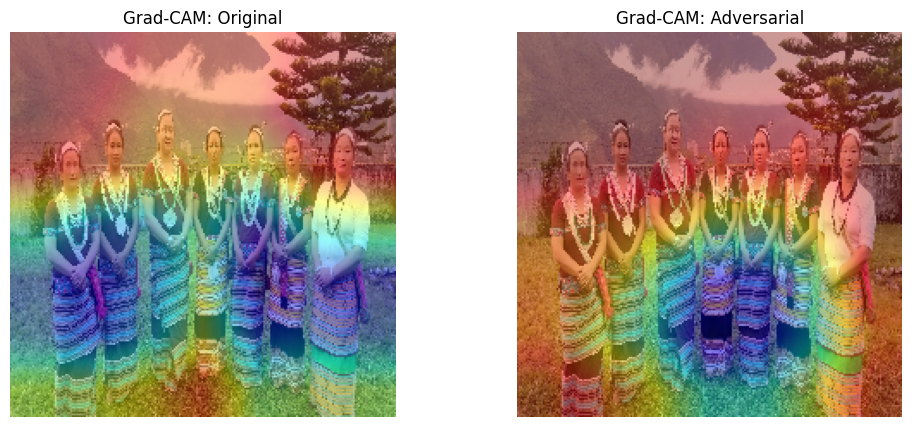

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Grad-CAM: Original")
plt.imshow(img_overlay_clean)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM: Adversarial")
plt.imshow(img_overlay_adv)
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K

def integrated_gradients(model, img, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=img.shape)
    img = tf.cast(img, tf.float32)
    baseline = tf.cast(baseline, tf.float32)

    alphas = tf.linspace(start=0.0, stop=1.0, num=steps)
    interpolated = baseline + alphas[:, tf.newaxis, tf.newaxis, tf.newaxis] * (img - baseline)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        pred_class = tf.argmax(preds[-1])
        outputs = preds[:, pred_class]

    grads = tape.gradient(outputs, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (img - baseline) * avg_grads
    return integrated_grads

In [ ]:
ig_clean = integrated_gradients(model, image)
ig_adv = integrated_gradients(model, adversarial_image)

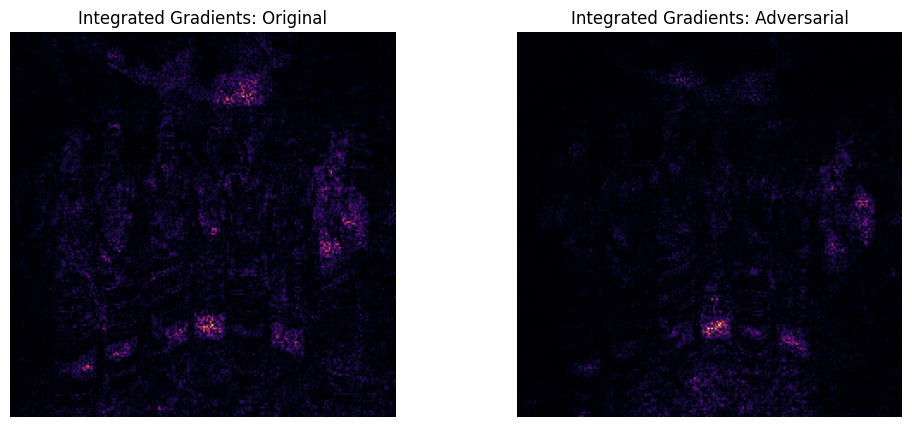

In [ ]:
def visualize_ig(attributions, title):
    attributions = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    attributions = attributions / tf.reduce_max(attributions)
    plt.imshow(attributions[0], cmap='inferno')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
visualize_ig(ig_clean, "Integrated Gradients: Original")

plt.subplot(1, 2, 2)
visualize_ig(ig_adv, "Integrated Gradients: Adversarial")
plt.show()

In [ ]:
def show_comparison(original_img, adv_img,
                    heatmap_clean, heatmap_adv,
                    ig_clean, ig_adv):
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2
    import tensorflow as tf

    def deprocess(img):
        img = (img + 1.0) / 2.0
        return np.clip(img, 0, 1)

    def overlay(heatmap, img):
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = np.uint8(255 * heatmap)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        img = ((img + 1) * 127.5).numpy().astype(np.uint8)
        return cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(14, 8))

    plt.subplot(3, 2, 1)
    plt.title("Original Image")
    plt.imshow(deprocess(original_img[0]))
    plt.axis("off")

    plt.subplot(3, 2, 3)
    plt.title("Grad-CAM: Original")
    plt.imshow(overlay(heatmap_clean, original_img[0]))
    plt.axis("off")

    plt.subplot(3, 2, 5)
    plt.title("Integrated Gradients: Original")
    ig_vis = tf.reduce_sum(tf.abs(ig_clean[0]), axis=-1)
    plt.imshow(ig_vis, cmap='inferno')
    plt.axis("off")

    plt.subplot(3, 2, 2)
    plt.title("Adversarial Image")
    plt.imshow(deprocess(adv_img[0]))
    plt.axis("off")

    plt.subplot(3, 2, 4)
    plt.title("Grad-CAM: Adversarial")
    plt.imshow(overlay(heatmap_adv, adv_img[0]))
    plt.axis("off")

    plt.subplot(3, 2, 6)
    plt.title("Integrated Gradients: Adversarial")
    ig_adv_vis = tf.reduce_sum(tf.abs(ig_adv[0]), axis=-1)
    plt.imshow(ig_adv_vis, cmap='inferno')
    plt.axis("off")

    plt.tight_layout()
    plt.show()


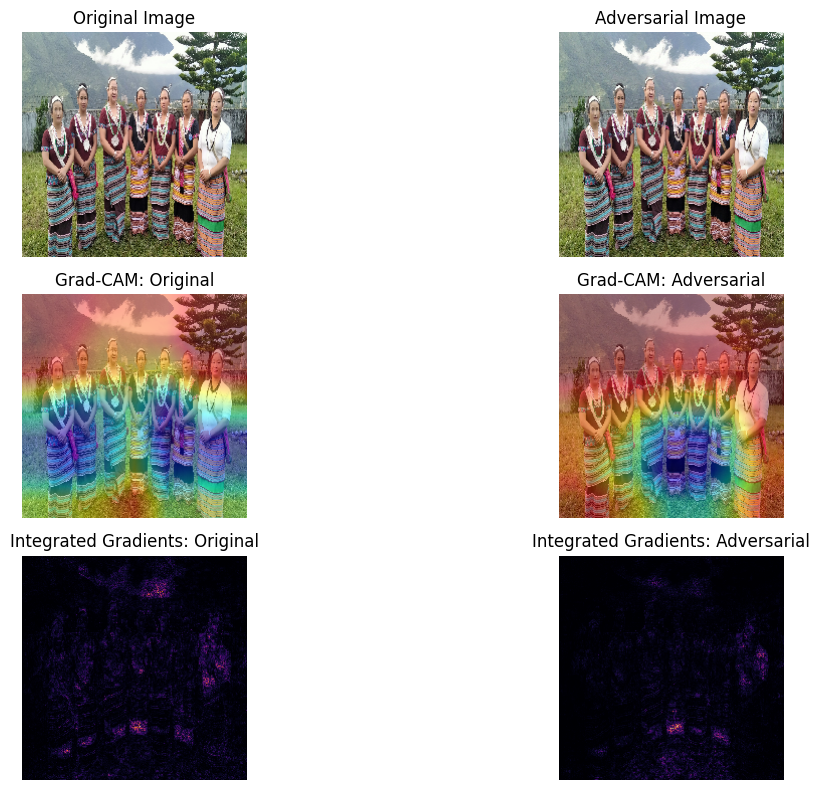

In [ ]:
show_comparison(image, adversarial_image, heatmap_clean, heatmap_adv, ig_clean, ig_adv)
